**Implementation of a Trinomial tree model for European call option**

(A)

*The algorithm*

We set the notation that:
\begin{align*}
s^n_k=S_0 u^{n
-k},\qquad n=0,1,...,N\quad k=0,1,...,2n
\end{align*}
is the $k^{th}$ possible stock price level at time $n$, and $V^n_k$ is the time-$n$ option value when the stock price is $s^n_k$. 

Then the pricing procedure is:

1.   Compute the option price at the terminal time $N$ which is simply the option payoff function, i.e. $V^N=g(S_N)$:
		\begin{align}
		V^N_k=g(S_0 u^{N-k}) \quad \text{for each }k=0,1,...,2N
		\end{align}

2.   Loop backward in time: for $n=N-1,N-2,...,0$, compute
		\begin{align*}
		V^{n}_k=e^{-r\triangle t}[q_uV^{n+1}_{k} + q_mV^{n+1}_{k+1} + q_dV^{n+1}_{k+2}]\quad\text{for each }k=0,1,...,2n
		\end{align*}
  
3.   The required time-zero option value is $V^0_0$

(B)

Load the usual packages

In [ ]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt

Implementation of the above pricing algorithm:

In [ ]:
def EuroTrinomialTree(s0, u, qu, qm, qd, R, N, payoff):
        
    # Create empty arrays to store the stock price and option value at each node
    V = np.zeros((2*N+1, N+1))
    S = np.zeros((2*N+1, N+1))
    
    # Set up S[k,n] = s0 * u^(n-k)
    for t in range(N+1):
      S[0:2*t+1, t] = s0 * u**np.arange(t, -t-1, -1)
    
    # Compute the option price at terminal time
    V[:,N] = payoff(S[:,N])
    
    # Loop backward in time
    for t in reversed(range(N)):
        V[0:2*t+1, t] = (qu * V[0:2*t+1,t+1] + qm * V[1:2*t+2,t+1] + qd * V[2:2*t+3, t+1]) / R    # The R is going to be taken as R=exp(r dt), which represents the interest rate factor
        
    return V, S     # get the function to return the whole tree of stock prices and option values

*Choosing the tree parameters*

There are a number of ways we can choose the tree parameters. We choose the Kamrad-Ritchken parametrisation here:
	\begin{align*}
	&q_u=\frac{1}{2\lambda^2} + \frac{(r-\frac{\sigma^2}{2})\sqrt{\triangle t}}{2\lambda \sigma}, \quad q_m = 1 - \frac{1}{\lambda^2}, \quad q_d=\frac{1}{2\lambda^2} - \frac{(r-\frac{\sigma^2}{2})\sqrt{\triangle t}}{2\lambda \sigma},\\
\\
&u=e^{\lambda \sigma \sqrt{\triangle t}},\quad m = 1, \quad d=e^{-\lambda \sigma \sqrt{\triangle t}}.
	\end{align*}

In [ ]:
def GetTrinomialKRPara(lamb, r, dt, sigma):
  u = np.exp(lamb * sigma * np.sqrt(dt))
  R = np.exp(r * dt)
  qu = 1/(2*lamb**2) + (r-sigma**2/2)*np.sqrt(dt)/(2*lamb*sigma)
  qm = 1 - 1/lamb**2
  qd = 1 - qu - qm
  return u, qu, qm, qd, R

Now we try to use a 2-period tree to price a European call option which payoff function is $(S_T-K)^{+}$. Parameters are: initial stock price $S_0=100$, strike price $K=100$, maturity $T=1$ year, interest rate $r=1\%$ and volatility $\sigma=20\%$.

In [ ]:
s0, r, T, sigma, K, lamb = 100, 0.01, 1, 0.2, 100, 1     # Option and market parameters
N = 2                                           # Number of periods
CallPayoff = lambda x : np.maximum(x - K, 0)     # The payoff function to be used: g(s)=max(S-K, 0)

u, qu, qm, qd, R = GetTrinomialKRPara(lamb, r, T/N, sigma)         # Get the KR parameters. Recall dt = T/N
V, S = EuroTrinomialTree(s0, u, qu, qm, qd, R, N, CallPayoff)  # Call the binomial tree function

Print the values of the V matrix which collects the values of $V^n_k$. Note that the values in the lower diagonal are not relevant.

In [ ]:
print(V)

[[ 7.52908129 15.68830736 32.68964411]
 [ 0.          7.29041085 15.19099102]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


In [ ]:
print(S)

[[100.         115.19099102 132.68964411]
 [  0.         100.         115.19099102]
 [  0.          86.81234454 100.        ]
 [  0.           0.          86.81234454]
 [  0.           0.          75.36383164]]


The required time-zero value of the option is $V^0_0$ which is 7.53.

*Convergence to Black-Scholes price*

We can study how the option price under the Trinomial tree behaves as the number of period in the tree $N$ varies. We first implement the Black-Scholes formula for call option for benchmarking purpose.

In [ ]:
def euro_vanilla_call(s0, K, T, r, sigma):
  d1 = (np.log(s0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
  d2 = (np.log(s0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
  return (s0 * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0) )

We are going to vary $N$ and then plot the Trinomial tree prices against $N$ with few different values of the free parameter $\lambda \in \{1, 1.25, 1.5, 1.75\}$. 

In [ ]:
BScall = euro_vanilla_call(s0, K, T, r, sigma)    # compute the theoretical Black-Scholes price of the call

N_range = np.arange(2,100,1)                   # A range of N that we consider
TrinomialPxs = []
num_trials = 4

# Loop over different values of N
for j in range(num_trials):
  TrinomialPx = np.zeros(len(N_range))             # An array to store the trinomial tree option prices under different N
  for i, N in enumerate(N_range):
    u, qu, qm, qd, R = GetTrinomialKRPara(lamb+0.25*j, r, T/N, sigma)     # the parameters depend on N since dt=T/N
    V, S = EuroTrinomialTree(s0, u, qu, qm, qd, R, N, CallPayoff)
    TrinomialPx[i] = V[0,0]
  TrinomialPxs.append(TrinomialPx)

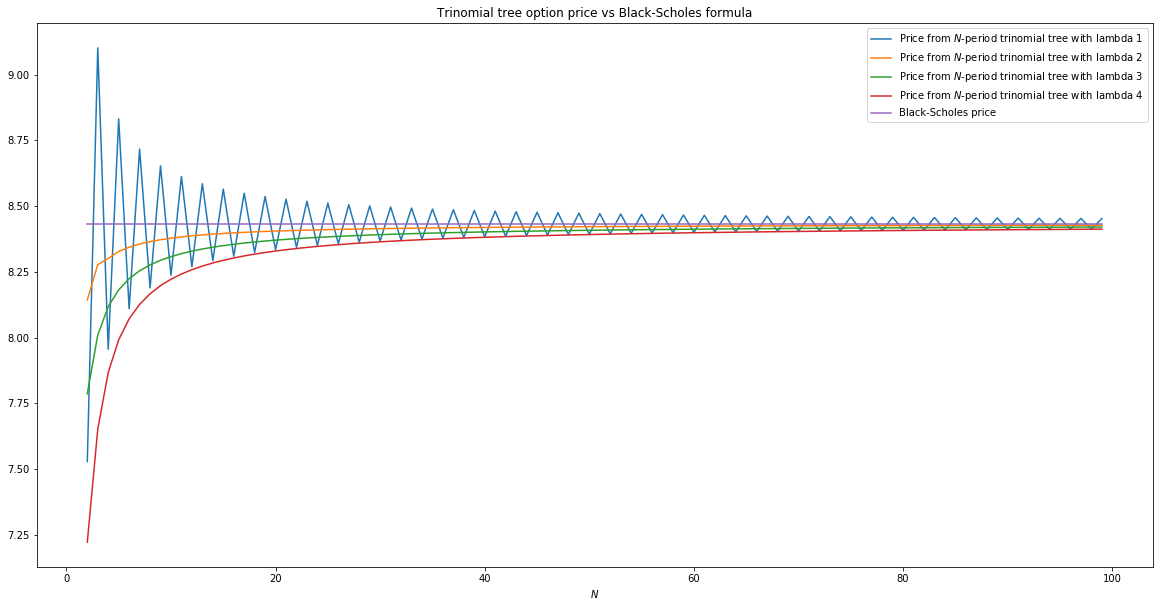

In [ ]:
fig, ax = plt.subplots(figsize = (20, 10))
for j in range(num_trials):
  ax.plot(N_range, TrinomialPxs[j], label='Price from $N$-period trinomial tree with lambda '+str(j+1)+'')
ax.plot(N_range, np.ones(len(N_range))*BScall, label='Black-Scholes price')
ax.set_xlabel('$N$')
ax.set_title('Trinomial tree option price vs Black-Scholes formula')
ax.legend()

We can see that as $N$ gets larger the price from Trinomial tree gets closer to the Black-Scholes theoretical price. When $N>80$, the error does not vary significantlly among all methods. 

When $\lambda = 1$, the trinomial tree degenerates into a binomial tree, so the price fluctuates around the theoretical price. When $\lambda > 1$, as $\lambda$ increases, the error between the obtained price and theoretical price increases too. 

When checking how the results change if we work with different values of $S_0$ and $\lambda$, to enhance the efficiency and accuracy of the model, we choose $N$ to start from 80.

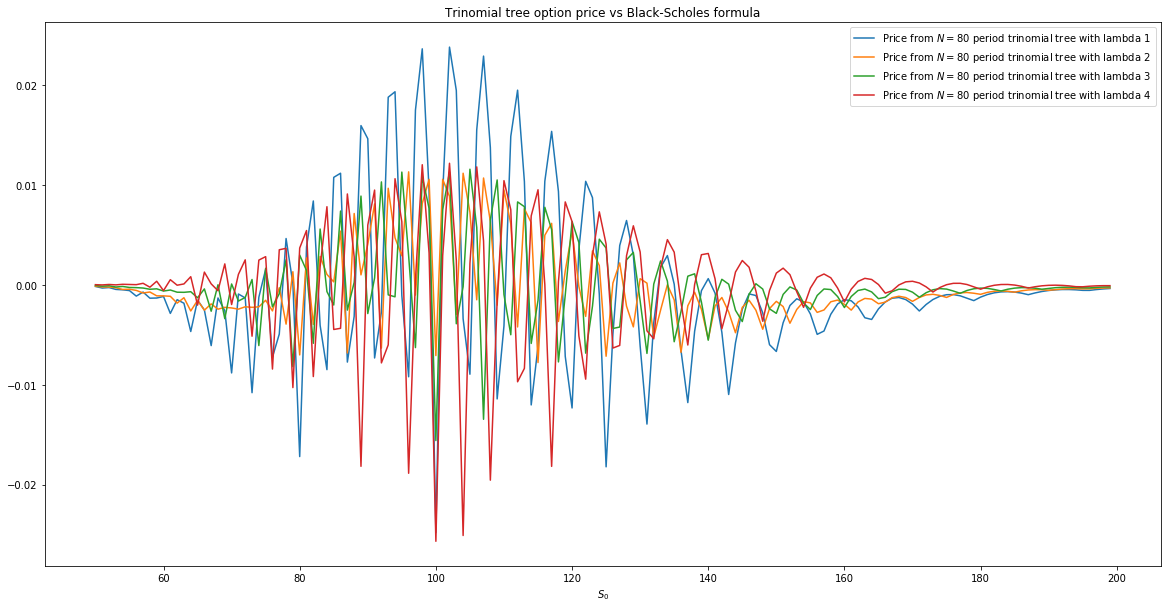

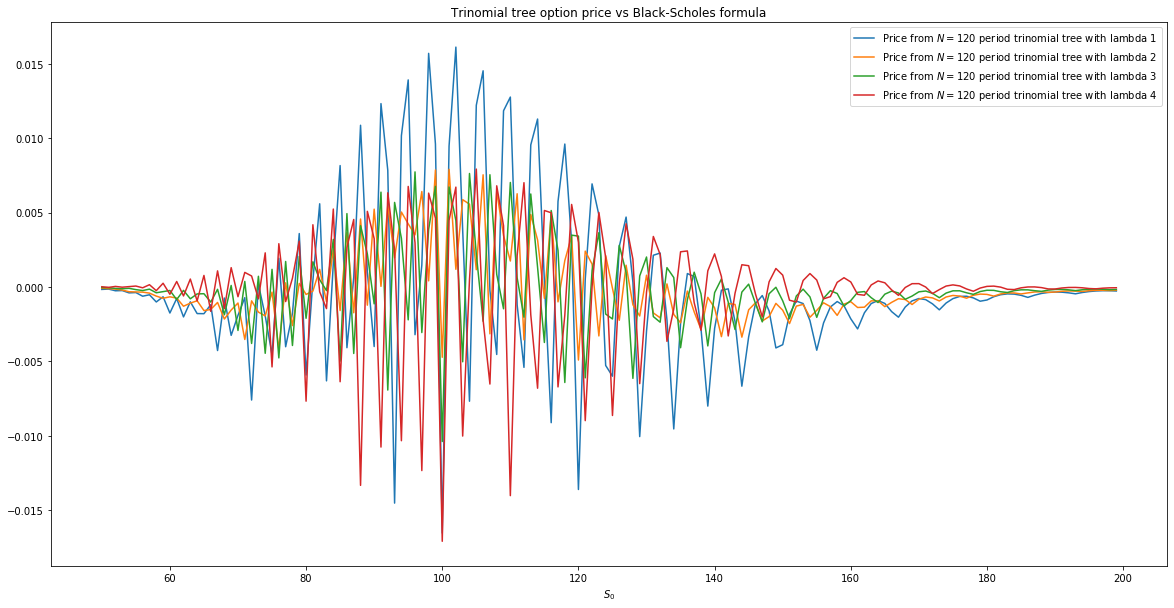

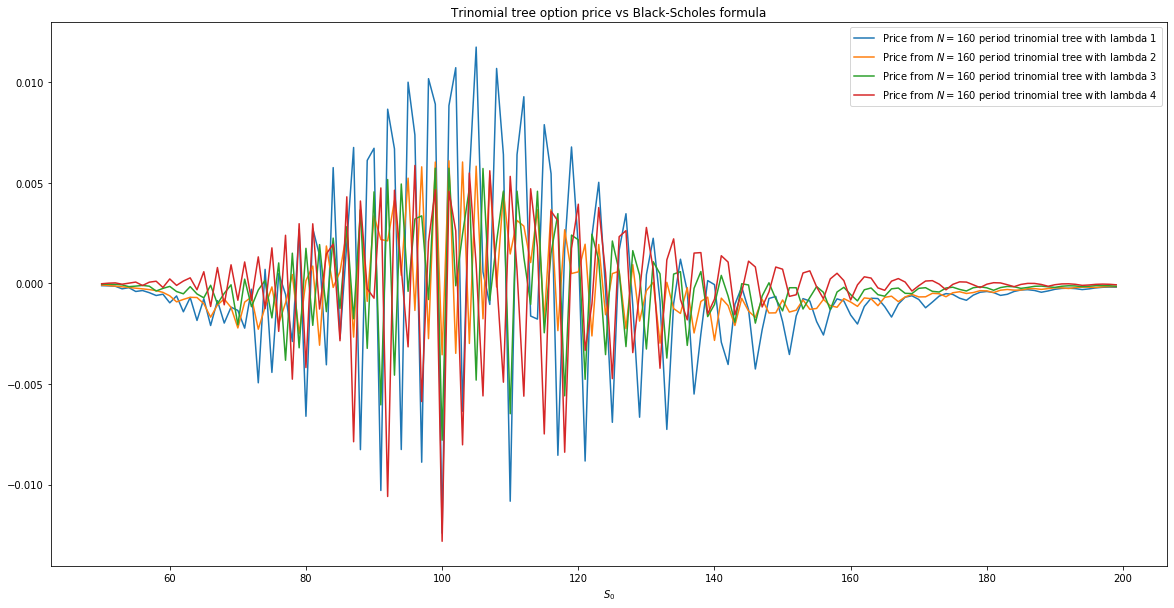

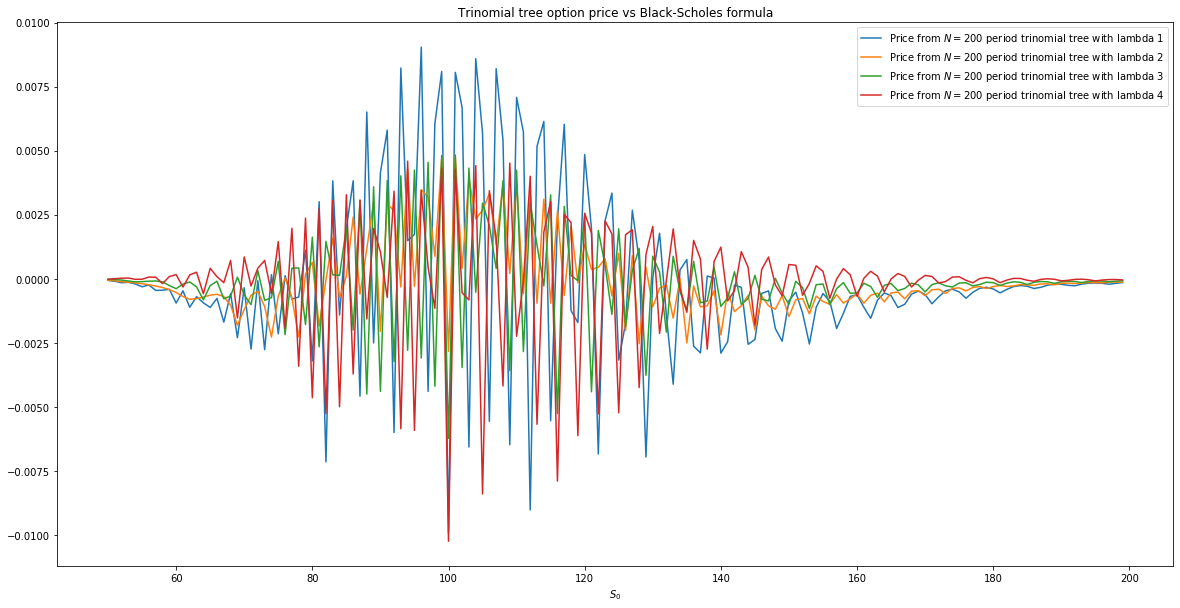

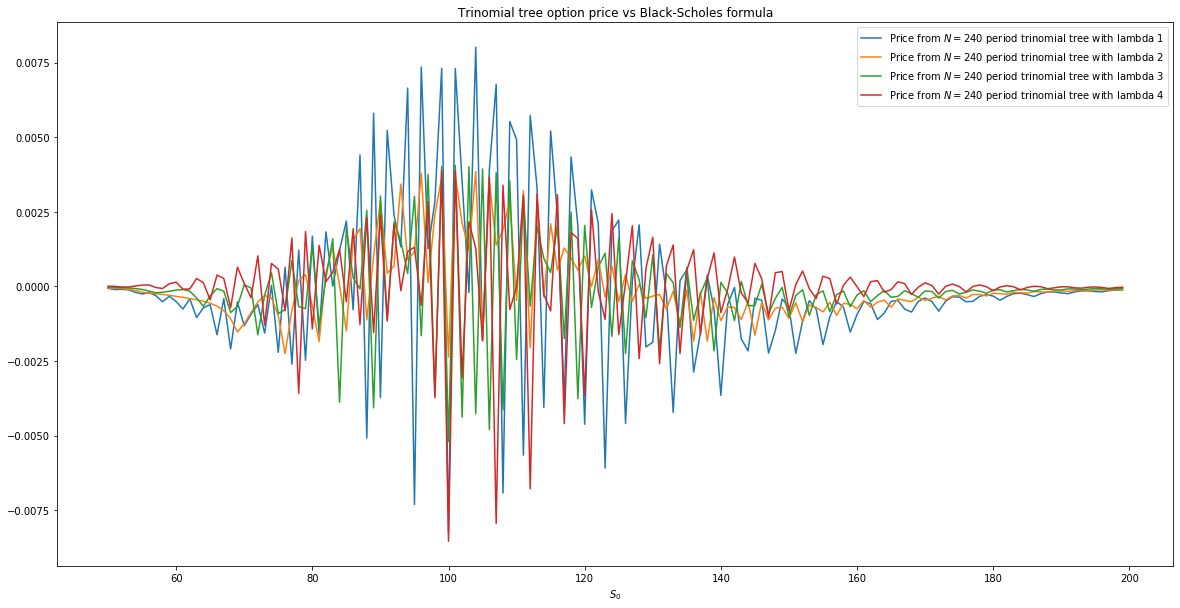

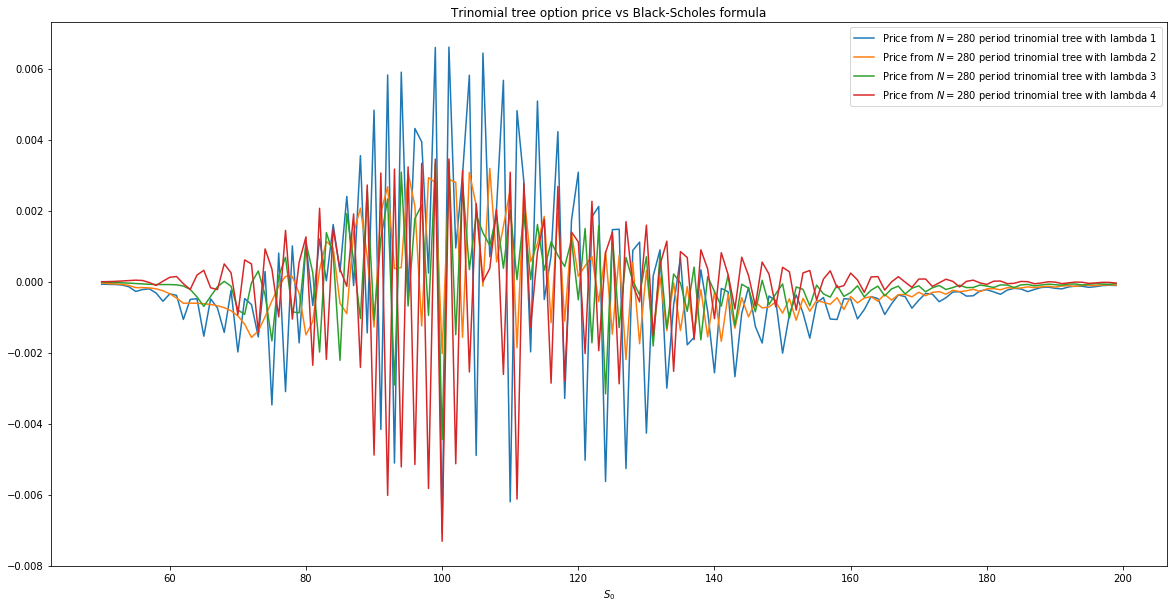

In [ ]:
s0_range = np.arange(50,200,1)
N_range = np.arange(80,300,40)
num_trials = 4

# Loop over different values of s0
for N in N_range:
  TrinomialPxs_s0 = []
  TheoreticalPx = np.zeros(len(s0_range))
  for j in range(num_trials):
    TrinomialPx = np.zeros(len(s0_range))             
    for i, s0 in enumerate(s0_range):
      u, qu, qm, qd, R = GetTrinomialKRPara(lamb+0.25*j, r, T/N, sigma)     
      V, S = EuroTrinomialTree(s0, u, qu, qm, qd, R, N, CallPayoff)
      TrinomialPx[i] = V[0,0]
      TheoreticalPx[i] = euro_vanilla_call(s0, K, T, r, sigma)       
    TrinomialPxs_s0.append(TrinomialPx)  
  fig, ax = plt.subplots(figsize=(20,10))
  for j in range(num_trials):
    ax.plot(s0_range, TrinomialPxs_s0[j] - TheoreticalPx, label='Price from $N='+str(N)+'$ period trinomial tree with lambda '+str(j+1)+'')
  ax.set_xlabel('$S_0$')
  ax.set_title('Trinomial tree option price vs Black-Scholes formula')
  ax.legend()


As $N$ increases, the error between the obtained price and theoretical price decreases. 

The error goes to maximum when $S_0$ is close to the strike price, i.e. when the option becomes at-the-money. This suggests that the randomness of value of the option brings about the numerical error in our trinomial tree method.

It is consistent with our previous observation that the method has the best performance when $\lambda = 1.25$.

(C)

In [ ]:
r, T, sigma, K, N = 0.01, 1, 0.2, 100, 500 
lamb = 1    
s0_range = np.arange(70,131,5)
num_trials = 4
Difference = np.zeros(len(s0_range))
TheoreticalPx = np.zeros(len(s0_range))
TrinomialPxs = []
Differences = []
TheoreticalPxs = []

for j in range(num_trials):
  TrinomialPx = np.zeros(len(s0_range))            
  for i, s0 in enumerate(s0_range):
    u, qu, qm, qd, R = GetTrinomialKRPara(lamb+0.25*j, r, T/N, sigma)   
    V, S = EuroTrinomialTree(s0, u, qu, qm, qd, R, N, CallPayoff)
    TrinomialPx[i] = V[0,0]
    TheoreticalPx[i] = euro_vanilla_call(s0, K, T, r, sigma)
  Difference = TrinomialPx - TheoreticalPx
  TrinomialPxs.append(TrinomialPx)
  Differences.append(Difference)
  TheoreticalPxs.append(TheoreticalPx)

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
print(Differences)

[array([-0.00121067, -0.00151831,  0.00106709, -0.00175044, -0.0010834 ,
       -0.0004261 , -0.00397241,  0.00222193,  0.00247438,  0.00027355,
       -0.00009953,  0.00134899,  0.00046233]), array([-0.00059522, -0.00025571, -0.00097354,  0.00085155,  0.00132179,
        0.00168765, -0.00113641,  0.0016487 ,  0.00161458,  0.00125246,
        0.00052556, -0.00097794,  0.00018162]), array([ 0.00003595,  0.00025924,  0.00050565, -0.00075475, -0.00034925,
        0.00005281, -0.00249222,  0.00157549, -0.00086411,  0.0012983 ,
        0.00099922,  0.00061939,  0.00049729]), array([ 0.00003807,  0.00054262,  0.00025741,  0.00112021,  0.00059159,
        0.00070541, -0.00409546, -0.0015836 , -0.00196614, -0.00199832,
        0.00102215,  0.00026947,  0.00018864])]


In [ ]:
import pandas as pd
pd.set_option('display.precision', 7)
diff_df = pd.DataFrame(Differences)

In [ ]:
diff_df 

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00


It is reasonable to choose $\lambda = 1.25$.